<a href="https://colab.research.google.com/github/jecampagne/interpolation/blob/main/image_interpolation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pylab inline
import numpy as np

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
import matplotlib.gridspec as gridspec
params = {'legend.fontsize':16,
          'figure.figsize': (8, 8),
         'axes.labelsize': 16,
         'axes.titlesize': 16,
         'xtick.labelsize':16,
         'ytick.labelsize': 16}
pylab.rcParams.update(params)

In [3]:
import matplotlib.ticker as mtick
def decibel_formatter(unit='dB'):
    def format_value(value, pos=None):
        dB = 10*np.log10(value)
        return f'{dB:.0f} {unit}'
    return format_value

# Understanding the  Gary M. Bernstein & Daniel Gruen 2014 article
 see https://arxiv.org/pdf/1401.2636.pdf

In [4]:
def pad_with(vector, pad_width, iaxis, kwargs):
    pad_value = kwargs.get('padder', 10.)
    vector[:pad_width[0]] = pad_value
    vector[-pad_width[1]:] = pad_value

In [5]:
def crop_at(img,cropx,cropy,off7x=0,off7y=0):
    y,x = img.shape
    startx = x//2-(cropx//2)+off7x
    starty = y//2-(cropy//2)+off7y
    return img[starty:starty+cropy,startx:startx+cropx]

In [6]:
def fullprint(*args, **kwargs):
  from pprint import pprint
  import numpy
  opt = numpy.get_printoptions()
  numpy.set_printoptions(threshold=numpy.inf)
  pprint(*args, **kwargs)
  numpy.set_printoptions(**opt)

In [7]:
def zero_tiny(x, threshold=1e-10):
  x[np.abs(x) < threshold] = 0
  return x

# Different interpolants in real & Fourier space

In [8]:
def Unity(x,ker,Jmax=5):
  js = np.arange(-Jmax,Jmax+1)
  X,Y = np.meshgrid(x,js)
  kxpj = ker(X+Y)
  return np.sum(kxpj,axis=0)

In [9]:
# Whittaker-Shannon sinc. interpolant
def sincInterp(x):
  return np.sinc(x)
def hatSincInterp(u):
  u = np.abs(u)
  return  np.piecewise(u,[u<0.5,u==0.5,u>0.5],[lambda x: 1., lambda x:0.5, lambda x:0])

In [10]:
def Bspline3(x):
  # nb. degre poly is 3
  x = np.abs(x)
  def p1(x):
    return 2/3+1/2* x * x * (x-2)
  def p2(x):
    return -1/6 *(x-2)*(x-2)*(x-2)
  return np.piecewise(x, [x<1., (x>=1)&(x<2.), x>=2],[lambda x:p1(x),lambda x:p2(x),lambda x: 0.])

def hatBspline3(u):
  s = np.sinc(u)
  s2 = s*s
  return s2 * s2

In [12]:
def hatBsplineCard3(u):
  sinpu = np.sin(np.pi*u)
  return hatBspline3(u)/(1-2/3*sinpu*sinpu)
def s3(n):
    n = n.astype(int)
    r3 = np.sqrt(3)
    return (-2*(n%2)+1)*r3/((2+r3)**(np.abs(n)))

def BsplineCard3(xin):
  xin = np.atleast_1d(xin)
  xshape=xin.shape
  x = xin.flatten()
  nmin = np.ceil(x-2).astype(int)
  nmax = np.floor(x+2).astype(int)
  res = []
  for i,x0 in enumerate(x):
    res.append(np.sum(np.array([s3(n)*Bspline3(x0-n) for n in np.arange(nmin[i],nmax[i]+1,1)])))
  return np.array(res).reshape(xshape)

In [14]:
def hatBspline5(u):
  s = np.sinc(u)
  s2 = s*s
  return s2 * s2 * s2

def hatBsplineCard5(u):
  b1 = 13/60
  b2 = 1/120
  b0 = 1 - b1 - b2
  piu = np.pi * u
  return hatBspline5(u)/(b0 + 2*b1*np.cos(2*piu) +2*b2*np.cos(4*piu))

In [ ]:
fig,axs = subplots(3,1,figsize=(8,8),tight_layout=True)

kerX = [sincInterp,Bspline3,BsplineCard3]
lab = ["Sinc",r"$\beta_3$",r"$\gamma_3$"]
lsStyle = ["-"]*len(lab)
kerU = [hatSincInterp,hatBspline3,hatBsplineCard3]


xv = np.linspace(-4,4,10_000)
uvsmall = np.linspace(-2,2,10_000)
uvlarge = np.linspace(0,5,10_000)
#uvtiny = np.linspace(-0.1,0.1,10_000)
for ik,(kX,kU) in enumerate(zip(kerX,kerU)):
  axs[0].plot(xv,kX(xv),label=lab[ik],ls=lsStyle[ik])
  axs[1].plot(uvsmall,kU(uvsmall),label=lab[ik],ls=lsStyle[ik])
  axs[2].plot(uvlarge,np.abs(kU(uvlarge)),label=lab[ik],ls=lsStyle[ik])
#  axs[3].plot(uvtiny,kU(1+uvtiny),label=lab[ik],ls=lsStyle[ik])

for ax in axs:
  ax.grid()
axs[0].legend(loc='center right', bbox_to_anchor=(1.35, 0.5));
#axs[1].legend()
axs[1].set_xlabel("u")

axs[2].set_yscale("log")
axs[2].set_ylim([1e-7,2]);
axs[2].set_xlabel("u")
axs[2].yaxis.set_major_formatter(mtick.FuncFormatter(decibel_formatter()))


axs[0].set_xlabel("x")
axs[0].axhline(0., linestyle='--', color='black')
axs[0].axvline(0., linestyle='--', color='black')



In [ ]:
figure(figsize=(6,4))
xs=np.linspace(-3,3,1000,endpoint=True)
beta4U = Unity(xs,Bspline3)
plot(xs,beta4U,label=r"$\sum_j \beta_3(x+j)$")
for j in np.arange(-5,6):
  plot(xs,Bspline3(xs+j))#,label=fr"$ \beta_4(x+{j}) $")
grid()
xlabel("x")
legend(loc="upper left");

In [ ]:
figure(figsize=(6,4))
xs=np.linspace(-3,3,1000,endpoint=True)
beta4U = Unity(xs,BsplineCard3)
plot(xs,beta4U,label=r"$\sum_j \gamma_3(x+j)$")
for j in np.arange(-5,6):
  plot(xs,BsplineCard3(xs+j))#,label=fr"$ \gamma_4(x+{j}) $")
grid()
xlabel("x")
#xlim([-3,3])
legend(loc="upper left");

In [ ]:
figure(figsize=(6,4))
xs=np.linspace(-3,3,1000,endpoint=True)
hatbeta4U = Unity(xs,hatBsplineCard3)
plot(xs,hatbeta4U,label=r"$\sum_j \hat{\gamma}_3(x+j)$")
for j in np.arange(-5,6):
  plot(xs,hatBspline3(xs+j))#,label=fr"$ \gamma_4(x+{j}) $")
grid()
xlabel("x")
legend(loc="upper left");

In [15]:
from scipy.special import sici

# Lanczos interpolant of degree m as well as the background conservation corrected version
def box(x):
  x = np.abs(x)
  return np.piecewise(x,[x<0.5,x==0.5,x>0.5],[lambda x: 1., lambda x:0.5, lambda x:0])

def siInt(x):
  si, _ = sici(x)
  return si

def lanczos(x,m):
  x = np.abs(x)
  return np.sinc(x)*np.sinc(x/m)*box(x/(2*m))

def hatlanczos(u,m):
  # the formula A12 are not correct.
  # Here Galsim code  https://github.com/GalSim-developers/GalSim/blob/releases/2.5/src/Interpolant.cpp
  # and validated with Mathematica
  u = np.abs(u)
  vp = m*(2*u+1)
  vm = m*(2*u-1)
  arg1 = vp+1
  arg2 = vp-1
  arg3 = vm-1
  arg4 = vm+1
  res = arg1*siInt(np.pi*arg1) - arg2*siInt(np.pi*arg2) + arg3*siInt(np.pi*arg3) - arg4*siInt(np.pi*arg4)
  return res/(2*np.pi)

def lanczos_norm(x,m):
  c1 = hatlanczos(1,m)
  return lanczos(x,m)*(1-2*c1*(np.cos(2*np.pi*x)-1)) # formula (24)

def hatlanczos_norm(u,m):
  c1 = hatlanczos(1,m)
  return (1+2*c1)*hatlanczos(u,m) - c1*(hatlanczos(u+1,m)+hatlanczos(u-1,m))  # formula (25)



In [16]:
from functools import partial
lanczos_raw3 = partial(lanczos,m=3)
hatlanczos_raw3 = partial(hatlanczos,m=3)
lanczos_raw4 = partial(lanczos,m=4)
hatlanczos_raw4 = partial(hatlanczos,m=4)
lanczos_raw5 = partial(lanczos,m=5)
hatlanczos_raw5 = partial(hatlanczos,m=5)


lanczos3 = partial(lanczos_norm,m=3)
hatlanczos3 = partial(hatlanczos_norm,m=3)

lanczos4 = partial(lanczos_norm,m=4)
hatlanczos4 = partial(hatlanczos_norm,m=4)

lanczos5 = partial(lanczos_norm,m=5)
hatlanczos5 = partial(hatlanczos_norm,m=5)

In [ ]:
fig = figure(figsize=(6,4))
ivals = np.arange(1,5)
kerU = [hatlanczos_raw3,hatlanczos_raw5]
lab = ["Lanczos-3","Lanczos-5"]
lsStyle = ["-"]*len(lab)
for  ik,ker in enumerate(kerU):
  scatter(ivals,ker(ivals),label=lab[ik],ls=lsStyle[ik])
legend()
grid()
yscale("log")
xlabel(r"$j$")
ylabel(r"$\hat{L}_m(j)$")
ylim([3e-7,3e-3])

In [ ]:
[hatlanczos(0,m) for m in [3,4,5,6,7,8]]

In [ ]:
def LanczosSum(x,n,m):
  res = []
  for val in x:
    s = np.sum(lanczos(val+n,m))
    res.append(s)
  return np.array(res)

In [ ]:
xs = np.linspace(-5,5,1000,endpoint=True)
data3 = LanczosSum(xs,np.arange(-5000,5001),3)
data5 = LanczosSum(xs,np.arange(-5000,5001),5)


In [ ]:
plot(xs,data3)
plot(xs,data5)
grid();

In [ ]:
def NormLanczosSum(x,n,m):
  res = []
  for val in x:
    s = np.sum(lanczos_norm(val+n,m))
    res.append(s)
  return np.array(res)

In [ ]:
1- NormLanczosSum(np.array([0,0.25,0.5,0.75]),np.arange(-5000,5001),3)

In [ ]:
1-NormLanczosSum(np.array([0,0.25,0.5,0.75]),np.arange(-5000,5001),5)

In [ ]:
xs = np.linspace(-5,5,1000,endpoint=True)
data3n = NormLanczosSum(xs,np.arange(-5000,5001),3)
data5n = NormLanczosSum(xs,np.arange(-5000,5001),5)


In [ ]:
figure(figsize=(7,5))
plot(xs,data3,label="Lanczos 3")
plot(xs,data5,label="Lanczos 5")
plot(xs,data3n,label="Lanczos Norm 3")
plot(xs,data5n,label="Lanczos Norm 5")
grid();
legend()
xlabel(r"$x$")
ylabel(r"$\sum_{j=-\infty}^{\infty} K(x-j)$");

In [ ]:
def hatLanczosSum(u,n,m):
  res = []
  for val in u:
    s = np.sum(hatlanczos(val+n,m))
    res.append(s)
  return np.array(res)


In [ ]:
us = np.linspace(-0.5,0.5,endpoint=True)
data3 = hatLanczosSum(us,np.arange(-3000,3001),3)
data5 = hatLanczosSum(us,np.arange(-3000,3001),5)


In [ ]:
plot(us,data3-1)
plot(us,data5-1)

In [ ]:
ivals = np.arange(-10,11)
ivals,hatlanczos(ivals,3), hatlanczos3(ivals)

In [17]:
def PlotKer(kerX,kerU,lab,lsStyle,ax20ylim,ax21ylim):
  fig = plt.figure(tight_layout=True,figsize=(8,10))
  gs = gridspec.GridSpec(3, 2)
  ax0 = fig.add_subplot(gs[0, :])
  ax1 = fig.add_subplot(gs[1, :])
  ax20 = fig.add_subplot(gs[2, 0])
  ax21 = fig.add_subplot(gs[2, 1])
  axs = [ax0,ax1,ax20,ax21]

  xv = np.linspace(-4,4,10_000)
  uvsmall = np.linspace(0,3,10_000)
  uvlarge = np.linspace(0,5,10_000)
  uvtiny1 = np.linspace(0.8,1.2,10_000)
  uvtiny0 = np.linspace(0,0.5,10_000)

  for ik,(kX,kU) in enumerate(zip(kerX,kerU)):
    ax0.plot(xv,kX(xv),label=lab[ik],ls=lsStyle[ik])
    ax1.plot(uvlarge,np.abs(kU(uvlarge)),label=lab[ik],ls=lsStyle[ik])
    ax20.plot(uvtiny0,kU(uvtiny0),label=lab[ik],ls=lsStyle[ik])
    ax21.plot(uvtiny1,kU(1+uvtiny1),label=lab[ik],ls=lsStyle[ik])

  for ax in axs:
    ax.grid()
  ax0.legend()#loc='center right', bbox_to_anchor=(1.35, 0.5));
  ax0.set_xlabel("x")
  ax0.axhline(0., linestyle='--', color='black')
  ax0.axvline(0., linestyle='--', color='black')

  ax1.set_yscale("log")
  ax1.set_xlabel("u")
  ax1.yaxis.set_major_formatter(mtick.FuncFormatter(decibel_formatter()))
  ax1.set_ylim([1e-7,2]);
  ax20.set_xlabel("u")
  ax20.set_ylim(ax20ylim);
  ax21.set_xlabel("u");
  ax21.set_ylim(ax21ylim);


In [ ]:
kerX = [sincInterp,lanczos_raw3,lanczos_raw4,lanczos_raw5]
lab = ["Sinc","Lanczos-3","Lanczos-4","Lanczos-5"]
lsStyle = ["-"]*len(lab)
kerU = [hatSincInterp,hatlanczos_raw3,hatlanczos_raw4,hatlanczos_raw5]

PlotKer(kerX,kerU,lab,lsStyle,ax20ylim=[0.98,1.02],ax21ylim=[-2e-4,2e-4])

In [18]:
# linear interpolant
def h1(x):
  x = np.abs(x)
  return np.piecewise(x,[x<1.,x>=1.],[lambda x: 1-x, lambda x:0])
def hat1(u):
  u = np.abs(u)
  s = np.sinc(u)
  return s*s

In [19]:
# cubic interpolant
def h3(x):
  # warning this is interpolator with perfect match at interger values
  x = np.abs(x)
  def p1(x): # x<1
    return 1+x*x*(1.5*x-2.5)
  def p2(x):
    return -0.5*(x-1.0)*(x-2.0)*(x-2.0)
  return np.piecewise(x, [x<1., (x>=1)&(x<2.), x>=2],[lambda x:p1(x),lambda x:p2(x),lambda x: 0.])

def hat3(u):
  # warning this is interpolator with perfect match at interger values
  u = np.abs(u)
  s = np.sinc(u)
  c = np.cos(np.pi * u)
  return s * s * s * (3.0 * s - 2.0 * c)


In [20]:
# quitic interpolants
# Gary original paper version
def h5Gary(x):
  x = np.abs(x)
  def p1(x): # x<1
    return 1.0 + x*x*x*(-95./12. + x*(23./2. + x*(-55./12.)))
  def p2(x): # 1<=x<2
    return (x-1.)*(x-2.)*(-23./4. + x*(29./2. + x*(-83./8. + x*(55./24.))))
  def p3(x): # 2<=x<3
    return (x-2.)*(x-3.)*(x-3.)*(-9./4. + x*(25./12. + x*(-11./24.)))
  return np.piecewise(x, [x<1., (x>=1)&(x<2.), (x>=2)&(x<3.), x>=3.],[lambda x:p1(x),lambda x:p2(x),lambda x:p3(x),lambda x: 0.])

def hat5Gary(u): #x-checked by Mathematica
  u = np.abs(u)
  s = np.sinc(u)
  s2 = s*s
  s4 = s2*s2
  s5 = s*s4
  piu = np.pi * u
  c = np.cos(piu)
  piu2 = piu*piu
  return s5 * (2.0 * (-27.0 + piu2) * c + s * (55.0 -19.0 * piu2))

# Galsim ALT_QUINTIC by Mike Jarvis (BUT MJ indicates that ALT_QUINTIC is not used)
def h5MJ(x):
  x = np.abs(x)
  def p1(x): # x<1
    return 1. + x*x*x*(-15./2. + x*(32./3. + x*(-25./6.)))
  def p2(x): # 1<=x<2
    return (x-1.)*(x-2.)*(-23./4. + x*(169./12. + x*(-39./4. + x*(25./12.))))
  def p3(x): # 2<=x<3
    return (x-2.)*(x-3.)*(x-3.)*(x-3.)*(3./4. + x*(-5./12.))
  return np.piecewise(x, [x<1., (x>=1)&(x<2.), (x>=2)&(x<3.), x>=3.],[lambda x:p1(x),lambda x:p2(x),lambda x:p3(x),lambda x: 0.])

def hat5MJ(u):
  u = np.abs(u)
  s = np.sinc(u)
  s2 = s*s
  s4 = s2*s2
  piu = np.pi * u
  c = np.cos(piu)
  piu2 = piu*piu
  return -s4*(s2*(12.*piu2-50.) + 44.*s*c + 5.);

# Version by Erik H. W. Meijering, Karel J. Zuiderveld, and Max A. Viergever
# IEEE TRANSACTIONS ON IMAGE PROCESSING, VOL. 8, NO. 2, FEBRUARY 1999 p 192

def h5MZVgen(x,c):
  x = np.abs(x)
  def p1(x): # x<1
    return 1. + x*x*(-5./2.+8*c + x*x*(45./16.-18*c + x*(-21./6.+10.*c)))
  def p2(x): # 1<=x<2
    return 5. + x*(-15. + x*(35./2. + x*(-10. + (45./16. - (5.*x)/16.)*x))) + \
      c * (-66. + x*(265. + x*(-392. + x*(270. + x*(-88. + 11.*x)))))
  def p3(x): # 2<=x<3
    return c*(-162. + x*(297. + x*(-216. + x*(78. + (-14. + x)*x))))
  return np.piecewise(x, [x<1., (x>=1)&(x<2.), (x>=2)&(x<3.), x>=3.],[lambda x:p1(x),lambda x:p2(x),lambda x:p3(x),lambda x: 0.])

def h5MZV(x):
  x = np.abs(x)
  def p1(x): # x<1
    return 1. + x*x * (-(17./8.) + (63./32. - (27.* x)/32.)*x*x)
  def p2(x): # 1<=x<2
    return 1./64.*(-2. + x) * (-1. + x) * (61. + x* (9. + x* (-45. + 13.* x)))
  def p3(x): # 2<=x<3
    return 3./64.* (-3. + x)*(-3. + x)*(-3. + x)*(-3. + x)*(-2. + x)
  return np.piecewise(x, [x<1., (x>=1)&(x<2.), (x>=2)&(x<3.), x>=3.],[lambda x:p1(x),lambda x:p2(x),lambda x:p3(x),lambda x: 0.])


def hat5MZV(u):
  u = np.abs(u)
  def fapp(u):
    u2 = u*u
    u4 = u2*u2
    P = 0.33333333333333333333 - 0.24271404762585718748 * u2 + 0.039750660445573631826 * u4
    Q = 1.0000000000000000000  + 0.25881829723136429944 * u2 + 0.026805791044710590408 * u4
    return P/Q

  def fno_app(u):
    piu = np.pi * u
    piu2 = piu*piu
    s = np.sinc(u)
    c = np.cos(piu)
    return (s-c)/piu2

  def f(u):
    return np.piecewise(u,[u<0.1,u>=0.1],[lambda u: fapp(u), lambda u: fno_app(u)])

  piu = np.pi * u
  piu2 = piu*piu
  c = np.cos(piu)
  s = np.sinc(u)
  s2 = s*s
  s3 = s*s2
  return 3./8. * s3 *( 35. * f(u) + s2 * (6.*c -15.*s) )

# A variation upon Gary quintic interpolant
# that I have cooked such that H^(l)[u=1]=0 for l in{1,...,5}
# nb. Gary in contrast is defined by h^(2)[x=0]=0
def h5JE(x):
  x = np.abs(x)
  def p1(x): # x<1
    x2 = x * x
    pi2 = np.pi * np.pi
    return (15. *(-12. + x2*(27. + x*(-13. + (-3. + x)*x))) \
            + pi2 * (12. - x2*(15. + x*(35. + x*(-63. + 25.*x)))))/(12.*(-15. +pi2))
  def p2(x): # 1<=x<2
    pi2 = np.pi * np.pi
    return ((-2. + x) * (-1 + x)*(-15.*(24. + x*(-3. + (-6. + x)*x))\
                + pi2 * (-48. + x * (153. + x*(-114. + 25.*x)))))/(24.*(-15. + pi2))
  def p3(x): # 2<=x<3
    pi2 = np.pi * np.pi
    return -(((-3. + x)*(-3.+x)*(-2. + x)*(-3.* (-7. + x)* x\
                + pi2*(-3. + x)*(-8. + 5.*x)))/(24.*(-15. + pi2)))
  return np.piecewise(x, [x<1., (x>=1)&(x<2.), (x>=2)&(x<3.), x>=3.],\
             [lambda x:p1(x),lambda x:p2(x),lambda x:p3(x),lambda x: 0.])

def hat5JE(u):
  u = np.abs(u)
  pi2 = np.pi * np.pi
  piu = np.pi * u
  piu2 = piu*piu
  c = np.cos(piu)
  ss = np.sin(piu)
  s = np.sinc(u)
  s2 = s*s
  s4 = s2*s2
  s5 = s*s4
  return (s5* (np.pi*(24.*np.pi* (-1. + u*u)*c - (39. + 7.*pi2)* u*ss)\
               + 5.*(-3. + 5.*pi2)*s))/(-15. + pi2)

In [21]:
# Magic Kernel used in Facebook & Instagram https://johncostella.com/magic/mks.pdf
def hatmagic3(u):
  u = np.abs(u)
  s = np.sinc(u)
  piu = np.pi * u
  sin = np.sin(piu)
  return s*s*s/(1-0.5*sin*sin)
def mks2021(x):
  x = np.abs(x)
  def p1(x): # x<1/2
    return 577./576. - 239./144. * x*x
  def p2(x): #1/2<=x<3/2
    return (239. - 379. * x + 140. * x*x )/144.
  def p3(x): #3/2<=x<5/2
    return (-130. + 113. * x - 24. * x*x )/144.
  def p4(x): #5/2<=x<7/2
    return (45. - 27.* x + 4. * x*x )/144.
  def p5(x): #7/2<=x<9/2
    return (-81. + 36. * x - 4. * x*x)/1152.
  return np.piecewise(x,
            [x<0.5, (x>=0.5)&(x<1.5), (x>=1.5)&(x<2.5), (x>=2.5)&(x<3.5), (x>=3.5)&(x<4.5), x>=4.5],
             [lambda x:p1(x),lambda x:p2(x),lambda x:p3(x),lambda x:p4(x),lambda x:p5(x),lambda x: 0.])

def hatmks2021(u):
  u = np.abs(u)
  piu = np.pi *u
  s = np.sinc(u)
  return s*s*s*(102. - 35.*np.cos(2*piu) + 6.* np.cos(4*piu) - np.cos(6*piu))/72.

In [ ]:
kerX = [sincInterp,h1,h3,h5MZV]
lab = ["Sinc","Linear","Cubic (MZV)","Quintic (MZV)"]
lsStyle = ["-"]*len(lab)
#lsStyle[-1]="--"
kerU = [hatSincInterp,hat1,hat3,hat5MZV]

PlotKer(kerX,kerU,lab,lsStyle,ax20ylim=[0.999,1.001],ax21ylim=[-2e-4,2e-4])


In [ ]:
fig,axs = subplots(3,1,figsize=(8,8))
#kerX = [sincInterp,lanczos3,lanczos5,h1,h3,h5Gary,h5MZV,mks2021]
#lab = ["Sinc","Lanczos Norm 3","Lanczos Norm 5","Linear","Cubic","Quintic (GB)","Quintic (MZV)","Quintic (JE)","mks2021"]
#lsStyle = ["-"]*len(lab)
#lsStyle[-1]="--"
#kerU = [hatSincInterp,hatlanczos3,hatlanczos5,hat1,hat3,hat5Gary,hat5MZV,hatmks2021]

kerX = [sincInterp,lanczos3,lanczos5,h3,h5Gary,h5MZV,h5JE, mks2021]
lab = ["Sinc","Lanczos Norm 3","Lanczos Norm 5","Cubic","Quintic (GB)","Quintic (MZV)","Quintic (JE)","mks2021"]
lsStyle = ["-"]*len(lab)
lsStyle[-1]="--"
kerU = [hatSincInterp,hatlanczos3,hatlanczos5,hat3,hat5Gary,hat5MZV,hat5JE, hatmks2021]


xv = np.linspace(-4,4,10_000)
uvsmall = np.linspace(0,3,10_000)
uvlarge = np.linspace(0,5,10_000)
#uvtiny = np.linspace(-0.1,0.1,10_000)
for ik,(kX,kU) in enumerate(zip(kerX,kerU)):
  axs[0].plot(xv,kX(xv),label=lab[ik],ls=lsStyle[ik])
  axs[1].plot(uvsmall,kU(uvsmall),label=lab[ik],ls=lsStyle[ik])
  axs[2].plot(uvlarge,np.abs(kU(uvlarge)),label=lab[ik],ls=lsStyle[ik])
#  axs[3].plot(uvtiny,kU(1+uvtiny),label=lab[ik],ls=lsStyle[ik])

for ax in axs:
  ax.grid()
axs[0].legend(loc='center right', bbox_to_anchor=(1.35, 0.5));
#axs[1].legend()
axs[2].set_yscale("log")
axs[2].set_ylim([1e-7,2]);


In [ ]:
hatBsplineCard3

Text(0, 1, 'x2 padding')

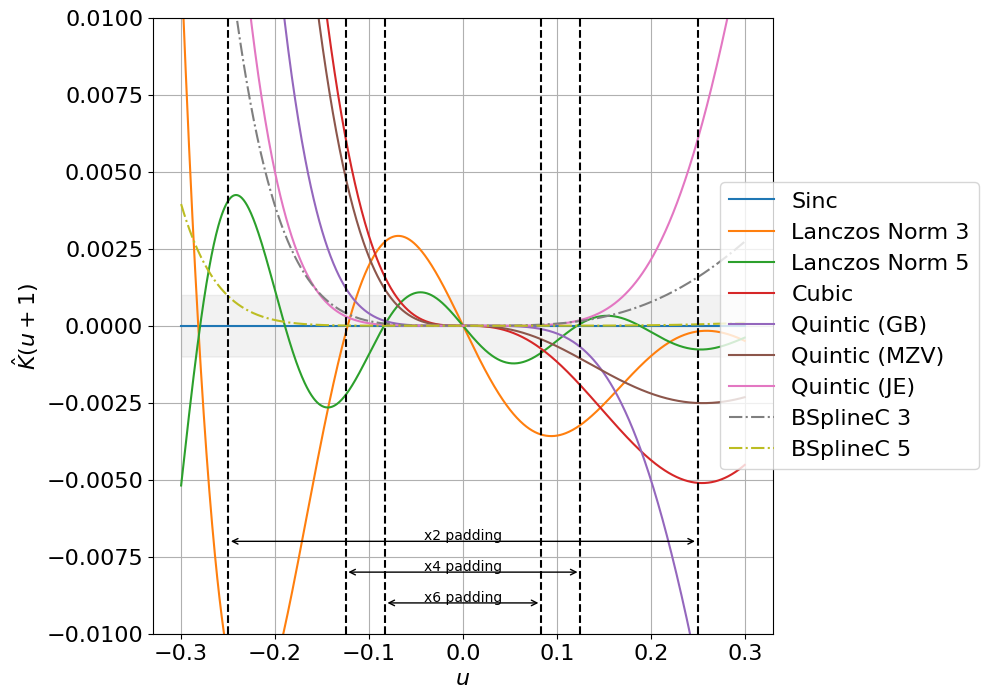

In [30]:
lab = ["Sinc","Lanczos Norm 3","Lanczos Norm 5","Cubic","Quintic (GB)","Quintic (MZV)","Quintic (JE)", "BSplineC 3", "BSplineC 5"]
lsStyle = ["-"]*len(lab)
lsStyle[-2]="-."
lsStyle[-1]="-."
kerU = [hatSincInterp,hatlanczos3,hatlanczos5,hat3,hat5Gary,hat5MZV,hat5JE,hatBsplineCard3,hatBsplineCard5]

#kerX = [sincInterp,lanczos3,lanczos5,h3,h5Gary,mks2021]
#lab = ["Sinc","Lanczos Norm 3","Lanczos Norm 5","Cubic","Quintic (GB)","mks2021"]
#lsStyle = ["-"]*len(lab)
#lsStyle[-1]="--"
#kerU = [hatSincInterp,hatlanczos3,hatlanczos5,hat3,hat5Gary,hatmks2021]

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

uv = np.linspace(-0.3,0.3,1000)
for ik,kU in enumerate(kerU):
  plot(uv,kU(uv+1),label=lab[ik],ls=lsStyle[ik],c=colors[ik])
ylim([-0.01,0.01])
grid();
legend(loc='center right', bbox_to_anchor=(1.35, 0.5));
# Fill in area under the curve and the horizontal lines
fill_between(x=uv, y1=0.001, y2=-0.001, color='gray',  interpolate=True, alpha=.1)
axvline(-0.25, linestyle='--', color='black')
axvline(0.25, linestyle='--', color='black');
axvline(-0.125, linestyle='--', color='black')
axvline(0.125, linestyle='--', color='black');
axvline(-0.5/6, linestyle='--', color='black')
axvline(0.5/6, linestyle='--', color='black');
ylabel(r"$\hat{K}(u+1)$")
xlabel(r"$u$");

plt.annotate(
    '', xy=(-0.5/6, -0.009), xycoords='data',
    xytext=(0.5/6, -0.009), textcoords='data',
    arrowprops={'arrowstyle': '<->'})
plt.annotate(
    'x6 padding', xy=(0, -0.009), xycoords='data', ha='center',
    xytext=(0, 1), textcoords='offset points')

plt.annotate(
    '', xy=(-0.5/4, -0.008), xycoords='data',
    xytext=(0.5/4, -0.008), textcoords='data',
    arrowprops={'arrowstyle': '<->'})
plt.annotate(
    'x4 padding', xy=(0, -0.008), xycoords='data', ha='center',
    xytext=(0, 1), textcoords='offset points')

plt.annotate(
    '', xy=(-0.5/2, -0.007), xycoords='data',
    xytext=(0.5/2, -0.007), textcoords='data',
    arrowprops={'arrowstyle': '<->'})
plt.annotate(
    'x2 padding', xy=(0, -0.007), xycoords='data', ha='center',
    xytext=(0, 1), textcoords='offset points')

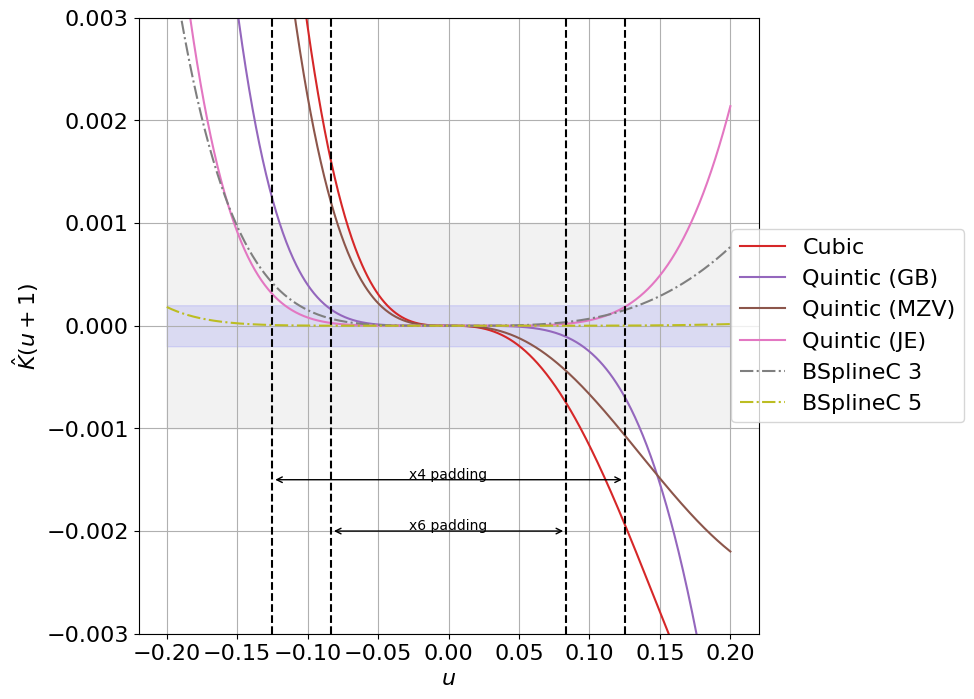

In [31]:
lab = ["Cubic","Quintic (GB)","Quintic (MZV)","Quintic (JE)","BSplineC 3", "BSplineC 5"]#,"mks2021"]
lsStyle = ["-"]*len(lab)
lsStyle[-2]="-."
lsStyle[-1]="-."
kerU = [hat3,hat5Gary,hat5MZV,hat5JE,hatBsplineCard3,hatBsplineCard5]#,hatmks2021]

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']


uv = np.linspace(-0.2,0.2,1000)
for ik,kU in enumerate(kerU):
  plot(uv,kU(uv+1),label=lab[ik],ls=lsStyle[ik],c=colors[ik+3])
ylim([-0.003,0.003])
grid();
legend(loc='center right', bbox_to_anchor=(1.35, 0.5));
# Fill in area under the curve and the horizontal lines
fill_between(x=uv, y1=0.0002, y2=-0.0002, color='blue',  interpolate=True, alpha=.1)
fill_between(x=uv, y1=0.001, y2=-0.001, color='gray',  interpolate=True, alpha=.1)
axvline(-0.125, linestyle='--', color='black')
axvline(0.125, linestyle='--', color='black');
#axvline(-0.25, linestyle='--', color='black')
#axvline(0.25, linestyle='--', color='black');
axvline(-0.5/6, linestyle='--', color='black')
axvline(0.5/6, linestyle='--', color='black');
ylabel(r"$\hat{K}(u+1)$")
xlabel(r"$u$");

plt.annotate(
    '', xy=(-0.5/6, -0.002), xycoords='data',
    xytext=(0.5/6, -0.002), textcoords='data',
    arrowprops={'arrowstyle': '<->'})
plt.annotate(
    'x6 padding', xy=(0, -0.002), xycoords='data', ha='center',
    xytext=(0, 1), textcoords='offset points')

plt.annotate(
    '', xy=(-0.5/4, -0.0015), xycoords='data',
    xytext=(0.5/4, -0.0015), textcoords='data',
    arrowprops={'arrowstyle': '<->'})
plt.annotate(
    'x4 padding', xy=(0, -0.0015), xycoords='data', ha='center',
    xytext=(0, 1), textcoords='offset points');

#plt.annotate(
#    '', xy=(-0.5/2, -0.0010), xycoords='data',
#    xytext=(0.5/2, -0.0010), textcoords='data',
#    arrowprops={'arrowstyle': '<->'})
#plt.annotate(
#    'x2 padding', xy=(0, -0.0010), xycoords='data', ha='center',
#    xytext=(0, 1), textcoords='offset points')

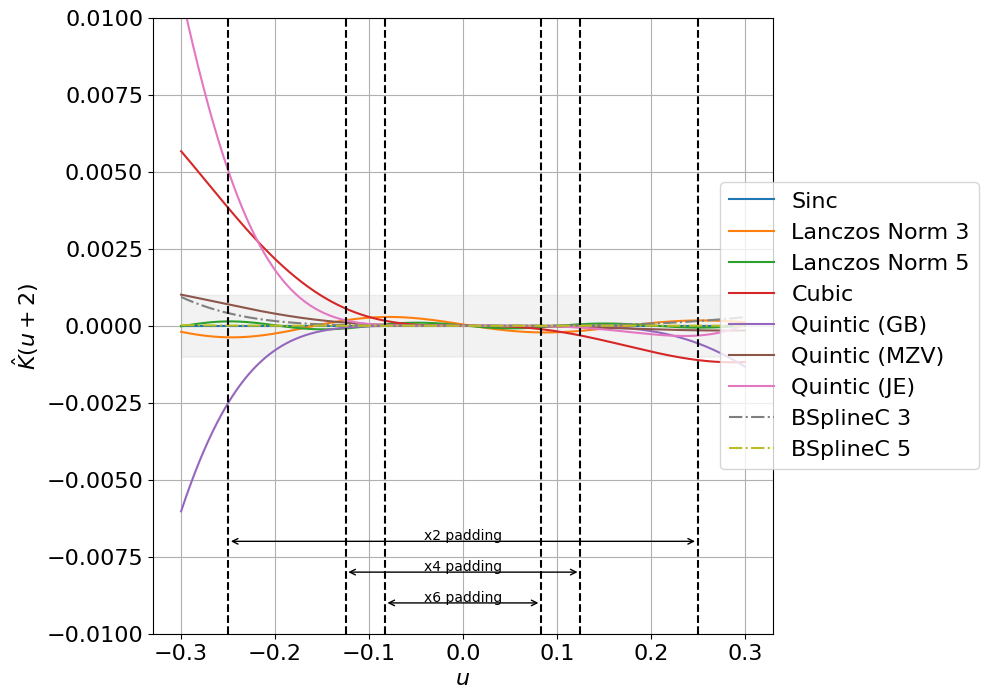

In [32]:
lab = ["Sinc","Lanczos Norm 3","Lanczos Norm 5","Cubic","Quintic (GB)","Quintic (MZV)","Quintic (JE)",
       "BSplineC 3","BSplineC 5"]#"mks2021"]
lsStyle = ["-"]*len(lab)
lsStyle[-2]="-."
lsStyle[-1]="-."
kerU = [hatSincInterp,hatlanczos3,hatlanczos5,hat3,hat5Gary,hat5MZV,hat5JE,hatBsplineCard3, hatBsplineCard5]#hatmks2021]

#kerX = [sincInterp,lanczos3,lanczos5,h3,h5Gary,mks2021]
#lab = ["Sinc","Lanczos Norm 3","Lanczos Norm 5","Cubic","Quintic (GB)","mks2021"]
#lsStyle = ["-"]*len(lab)
#lsStyle[-1]="--"
#kerU = [hatSincInterp,hatlanczos3,hatlanczos5,hat3,hat5Gary,hatmks2021]

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

uv = np.linspace(-0.3,0.3,1000)
for ik,kU in enumerate(kerU):
  plot(uv,kU(uv+2),label=lab[ik],ls=lsStyle[ik],c=colors[ik])
ylim([-0.01,0.01])
grid();
legend(loc='center right', bbox_to_anchor=(1.35, 0.5));
# Fill in area under the curve and the horizontal lines
fill_between(x=uv, y1=0.001, y2=-0.001, color='gray',  interpolate=True, alpha=.1)
axvline(-0.25, linestyle='--', color='black')
axvline(0.25, linestyle='--', color='black');
axvline(-0.125, linestyle='--', color='black')
axvline(0.125, linestyle='--', color='black');
axvline(-0.5/6, linestyle='--', color='black')
axvline(0.5/6, linestyle='--', color='black');
ylabel(r"$\hat{K}(u+2)$")
xlabel(r"$u$");

plt.annotate(
    '', xy=(-0.5/6, -0.009), xycoords='data',
    xytext=(0.5/6, -0.009), textcoords='data',
    arrowprops={'arrowstyle': '<->'})
plt.annotate(
    'x6 padding', xy=(0, -0.009), xycoords='data', ha='center',
    xytext=(0, 1), textcoords='offset points')

plt.annotate(
    '', xy=(-0.5/4, -0.008), xycoords='data',
    xytext=(0.5/4, -0.008), textcoords='data',
    arrowprops={'arrowstyle': '<->'})
plt.annotate(
    'x4 padding', xy=(0, -0.008), xycoords='data', ha='center',
    xytext=(0, 1), textcoords='offset points')

plt.annotate(
    '', xy=(-0.5/2, -0.007), xycoords='data',
    xytext=(0.5/2, -0.007), textcoords='data',
    arrowprops={'arrowstyle': '<->'})
plt.annotate(
    'x2 padding', xy=(0, -0.007), xycoords='data', ha='center',
    xytext=(0, 1), textcoords='offset points');

In [33]:
def E0(u,ker,n=5):
  sum=0
  for j in range(1,n+1):
    sum += ker(j+u)+ker(j-u)
  return sum

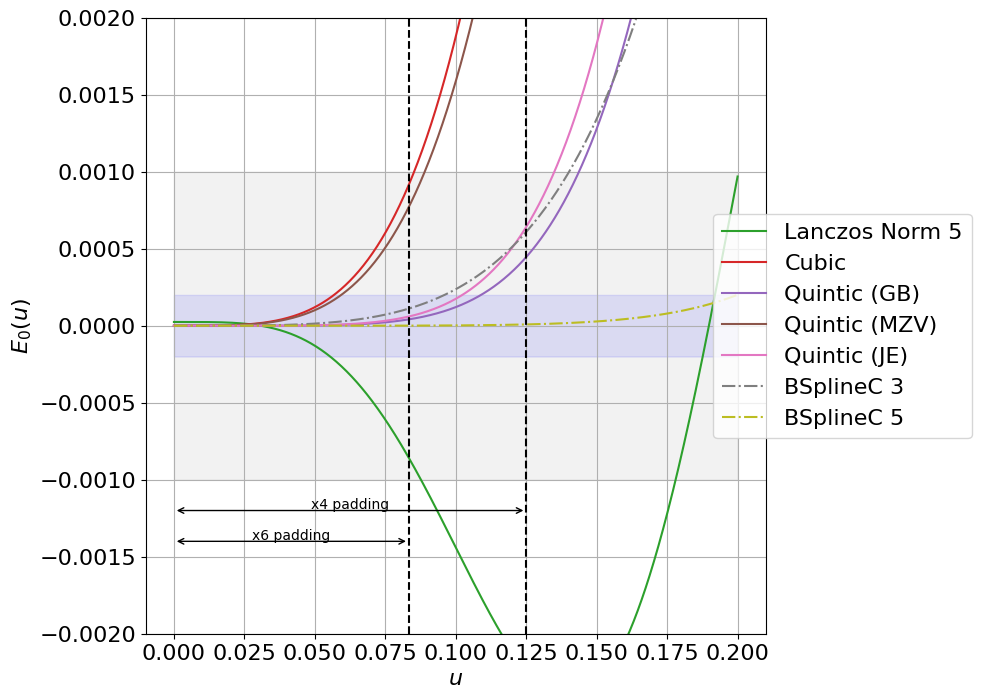

In [36]:
lab = ["Lanczos Norm 5", "Cubic","Quintic (GB)","Quintic (MZV)","Quintic (JE)","BSplineC 3","BSplineC 5"]#,"mks2021"]
lsStyle = ["-"]*len(lab)
lsStyle[-2]="-."
lsStyle[-1]="-."
kerU = [hatlanczos5,hat3,hat5Gary,hat5MZV,hat5JE,hatBsplineCard3, hatBsplineCard5]#,hatmks2021]

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']


uv = np.linspace(0,0.2,1000)
for ik,kU in enumerate(kerU):
  plot(uv,E0(uv,kU),label=lab[ik],ls=lsStyle[ik],c=colors[ik+2])
ylim([-0.002,0.002])
grid();
legend(loc='center right', bbox_to_anchor=(1.35, 0.5));
# Fill in area under the curve and the horizontal lines
fill_between(x=uv, y1=0.0002, y2=-0.0002, color='blue',  interpolate=True, alpha=.1)
fill_between(x=uv, y1=0.001, y2=-0.001, color='gray',  interpolate=True, alpha=.1)
#axvline(-0.125, linestyle='--', color='black')
axvline(0.125, linestyle='--', color='black');
#axvline(-0.25, linestyle='--', color='black')
#axvline(0.25, linestyle='--', color='black');
#axvline(-0.5/6, linestyle='--', color='black')
axvline(0.5/6, linestyle='--', color='black');
ylabel(r"$E_0(u)$")
xlabel(r"$u$");

plt.annotate(
    '', xy=(0, -0.0014), xycoords='data',
    xytext=(0.5/6, -0.0014), textcoords='data',
    arrowprops={'arrowstyle': '<->'})
plt.annotate(
    'x6 padding', xy=(0.5/12, -0.0014), xycoords='data', ha='center',
    xytext=(0, 1), textcoords='offset points')

plt.annotate(
    '', xy=(0, -0.0012), xycoords='data',
    xytext=(0.5/4, -0.0012), textcoords='data',
    arrowprops={'arrowstyle': '<->'})
plt.annotate(
    'x4 padding', xy=(0.5/8, -0.0012), xycoords='data', ha='center',
    xytext=(0, 1), textcoords='offset points');


In [ ]:
lab = ["Lanczos Norm 3","Lanczos Norm 5","Cubic","Quintic (GB)","Quintic (MZV)","Quintic (JE)","mks2021"]
lsStyle = ["-"]*len(lab)
#lsStyle[-2]="--"
lsStyle[-1]="-."
kerU = [hatlanczos3,hatlanczos5,hat3,hat5Gary,hat5MZV,hat5JE,hatmks2021]

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

uv = np.linspace(0,5,10_000)
for ik,kU in enumerate(kerU):
  plot(uv,np.abs(kU(uv)),label=lab[ik],ls=lsStyle[ik],c=colors[ik+1])
ylim([0,0.003])
grid();
legend(loc='center right', bbox_to_anchor=(1.35, 0.5));
axhline(0.001, linestyle='--', color='black');

# Make a image 32x32

In [ ]:
from google.colab import drive
drive.mount('/content/drive')



In [ ]:
cd /content/drive/MyDrive/interpolPoly/

In [ ]:
imgOrig = plt.imread("bullseye_32x32.png")
imshow(imgOrig,"gray_r");colorbar();
title("Original image 32x32");

In [ ]:
scatter(np.arange(32),imgOrig[:,16]);
plot(imgOrig[:,16]);

In [ ]:
N1o,N2o=imgOrig.shape

# Interpolation

In [ ]:
def interp_deprecated(img,x1,x2,ker):
  N1,N2 = img.shape
  res=[h3(x-p) for p in range(N1) for x in x1]
  mtxKx = np.array(res).reshape((N1,-1))
  res=[h3(x-p) for p in range(N2) for x in x2]
  mtxKy = np.array(res).reshape((N2,-1))

  # mtxKx.T .       I(N1,N2) . mtxKy
  #print(mtxKx.T.shape,img.shape,mtxKy.shape)
  return mtxKx.T @ img @  mtxKy

In [ ]:
def interpX(img,x1,x2,ker):
  N1,N2 = img.shape
  res=[h3(x-p) for p in range(-N1//2,N1//2,1) for x in x1]
  mtxKx = np.array(res).reshape((N1,-1))
  res=[h3(x-p) for p in range(-N2//2,N2//2,1) for x in x2]
  mtxKy = np.array(res).reshape((N2,-1))

  # mtxKx.T .       I(N1,N2) . mtxKy
  #print(mtxKx.T.shape,img.shape,mtxKy.shape)
  return mtxKx.T @ img @  mtxKy

From the original 32x32 images, inyterpolate in a x2 oversample grid

In [ ]:
N1ov = 2*N1o
N2ov = 2*N2o
N1o,N2o,N1ov,N2ov

In [ ]:
#x1 = np.arange(0,N1o,N1o/N1ov)#   np.linspace(0,N1,2*N1,endpoint=False)   # care with linespace
#x2 = np.arange(0,N2o,N2o/N2ov)#   np.linspace(0,N2,2*N2,endpoint=False)
#test = interp(img,x1,x2,h3)
#test.min(), test.max()

In [ ]:
x1 = np.arange(-N1o//2,N1o//2,N1o/N1ov)
x2 = np.arange(-N2o//2,N2o//2,N1o/N1ov)
orig_x2 = interpX(imgOrig,x1,x2,lanczos3)     #<------------ Figure 2
imshow(orig_x2,"gray_r"); colorbar();
title("Original image 2x oversampled (Lanczos norm 3rd)");

In [ ]:
scatter(np.arange(64),orig_x2[:,32]);
plot(orig_x2[:,32]);

Pad this 32x32 original image to get a 128x128 image before x->u DFT

---



In [ ]:
orig_pad_128 = np.pad(imgOrig, (128-32)//2, pad_with, padder=0.)

In [ ]:
orig_pad_128.shape

In [ ]:
imshow(orig_pad_128,"gray_r"); colorbar();
title("Original image padded to 128x128");

In [ ]:
scatter(np.arange(128),orig_pad_128[:,64]);
plot(orig_pad_128[:,64]);

# find DFT in 1D & 2D as defined by Gary et al.

In [ ]:
x=np.random.normal(size=(10,))

In [ ]:
def dft1D(x):
  # mimic the numpy FFT
  N = x.shape[0]
  mtx = np.array([np.exp(-2.0*1j*np.pi * m * k/N) for m in range(N) for k in range(N)]).reshape(N,-1)
  #print(mtx.shape, N)
  return mtx @ x

In [ ]:
def invdft1D(x):
  # mimic the numpy iFFT
  N = x.shape[0]
  mtx = np.array([np.exp(2.0*1j*np.pi * m * k/N) for m in range(N) for k in range(N)]).reshape(N,-1)
  return (mtx @ x)/N

In [ ]:
def dft1Dshift(x):
  # mimic the Gary et al FFT
  N = x.shape[0]
  mtx = np.array([np.exp(-2.0*1j*np.pi * m * k/N) for m in range(-N//2,N//2) for k in range(-N//2,N//2)]).reshape(N,-1)
  #print(mtx.shape, N)
  return mtx @ x

In [ ]:
def npdft1Dshift(x):
  # mimic Gary et al 1D DFT using numpy FFT
  return np.fft.fftshift(np.fft.fft(x))*np.array([(-1)**k for k in range(-x.shape[0]//2,x.shape[0]//2)])

In [ ]:
def invdft1Dshift(x):
  # mimic the Gary et al iFFT
  N = x.shape[0]
  mtx = np.array([np.exp(2.0*1j*np.pi * m * k/N) for m in range(-N//2,N//2) for k in range(-N//2,N//2)]).reshape(N,-1)
  #print(mtx.shape, N)
  return (mtx @ x)/N

In [ ]:
def npinvdft1Dshift(x):
  # mimic Gary et al 1D i DFT using numpy iFFT
  return np.fft.ifftshift(np.fft.ifft(x))*np.array([(-1)**k for k in range(-x.shape[0]//2,x.shape[0]//2)])

In [ ]:
np.allclose(dft1D(x),np.fft.fft(x))  # peddestrian DFT mimic numpy DFT

In [ ]:
np.allclose(invdft1D(x),np.fft.ifft(x)) # peddestrian iDFT mimic numpy iDFT

In [ ]:
np.allclose(dft1Dshift(x),npdft1Dshift(x)) # numpy FFT mimic Gary DFT

In [ ]:
np.allclose(npinvdft1Dshift(x),invdft1Dshift(x))# numpy iFFT mimic Gary iDFT

In [ ]:
np.allclose(invdft1D(dft1D(x)),x) # self consistance

In [ ]:
np.allclose(invdft1Dshift(dft1Dshift(x)),x) # self consistance

In [ ]:
np.allclose(npinvdft1Dshift(npdft1Dshift(x)),x) # self consistance

In [ ]:
x=np.random.normal(size=(4,6))

In [ ]:
x.shape

In [ ]:
def dft2D(x):
  # mimic the numpy FFT
  N1,N2 = x.shape
  mtx1 = np.array([np.exp(-2.0*1j*np.pi * n1 * k1/N1) for n1 in range(N1) for k1 in range(N1)]).reshape(N1,-1)
  mtx2 = np.array([np.exp(-2.0*1j*np.pi * n2 * k2/N2) for n2 in range(N2) for k2 in range(N2)]).reshape(N2,-1)
  return  mtx1.T @ x @ mtx2

In [ ]:
np.allclose(dft2D(x),np.fft.fft2(x))

In [ ]:
def dft2Dshift(x):
  # mimic the Gary et al FFT
  N1,N2 = x.shape
  mtx1 = np.array([np.exp(-2.0*1j*np.pi * n1 * k1/N1) for n1 in range(-N1//2,N1//2) for k1 in range(-N1//2,N1//2)]).reshape(N1,-1)
  mtx2 = np.array([np.exp(-2.0*1j*np.pi * n2 * k2/N2) for n2 in range(-N2//2,N2//2) for k2 in range(-N2//2,N2//2)]).reshape(N2,-1)
  return  mtx1.T @ x @ mtx2

In [ ]:
def npdft2Dshift(x):
  # mimic Gary et al 2D DFT using numpy FFT
  N1,N2 = x.shape
  mtxsig = np.array([(-1)**(k1+k2) for k1 in range(-N1//2,N1//2) for k2 in range(-N2//2,N2//2)]).reshape(N1,N2)
  return np.fft.fftshift(np.fft.fft2(x)) * mtxsig

In [ ]:
np.allclose(dft2Dshift(x),npdft2Dshift(x))

In [ ]:
def invdft2D(x):
  # mimic the numpy iFFT
  N1,N2 = x.shape
  mtx1 = np.array([np.exp(2.0*1j*np.pi * n1 * k1/N1) for n1 in range(N1) for k1 in range(N1)]).reshape(N1,-1)
  mtx2 = np.array([np.exp(2.0*1j*np.pi * n2 * k2/N2) for n2 in range(N2) for k2 in range(N2)]).reshape(N2,-1)
  return  (mtx1.T @ x @ mtx2)/(N1*N2)

In [ ]:
np.allclose(invdft2D(x),np.fft.ifft2(x))

In [ ]:
def invdft2Dshift(x):
  # mimic the Gary et al iFFT
  N1,N2 = x.shape
  mtx1 = np.array([np.exp(2.0*1j*np.pi * n1 * k1/N1) for n1 in range(-N1//2,N1//2) for k1 in range(-N1//2,N1//2)]).reshape(N1,-1)
  mtx2 = np.array([np.exp(2.0*1j*np.pi * n2 * k2/N2) for n2 in range(-N2//2,N2//2) for k2 in range(-N2//2,N2//2)]).reshape(N2,-1)
  return  (mtx1.T @ x @ mtx2)/(N1*N2)

In [ ]:
np.allclose(invdft2Dshift(dft2Dshift(x)),x)

In [ ]:
def npinvdft2Dshift(x):
  # mimic Gary et al 2D DFT using numpy FFT
  N1,N2 = x.shape
  mtxsig = np.array([(-1)**(k1+k2) for k1 in range(-N1//2,N1//2) for k2 in range(-N2//2,N2//2)]).reshape(N1,N2)
  return np.fft.ifftshift(np.fft.ifft2(x)) * mtxsig

In [ ]:
np.allclose(invdft2Dshift(x),npinvdft2Dshift(x))

In [ ]:
np.allclose(npinvdft2Dshift(npdft2Dshift(x)),x)

So, we can use npdft2Dshift and npinvdft2Dshift to perform Gary et al 2D FFT and inverse 2D FFT.

# Interpolation

In [ ]:
def KuSincWrapped(u,N):
  # "sinc kernel wrapped"
  return np.exp(1j * np.pi * u) * np.sinc(N*u)/np.sinc(u) # formule (10)

In [ ]:
def lanczos_p(x,m,N):
  x = np.abs(x)
  th=m/N
  return np.piecewise(x, [x<th,x>=th],[lambda x: lanczos(N*x,m)/lanczos(x,m), lambda x:0])
def lanczosWrapped(u,N,m=3):
    return np.exp(1j * np.pi * u) * np.sign(0.5-np.floor(u+0.5)%2)*lanczos_p(u-np.floor(u+0.5),m,N)

In [ ]:
u=np.linspace(-2.5,2.5,10_000)
for n in [5,10,100]:
  plot(u,np.abs(np.sinc(n*u)/np.sinc(u)),label=f"N={n}")
xlabel("x")
legend()
title(r"$|sinc(Nx)/sinc(x)|$");

In [ ]:
u=np.linspace(-2.5,2.5,10_000)
plot(u,np.sinc(32*u)/np.sinc(u),label="Periodic Sinc")
m=3
#plot(u,lanczos3(32*u)-lanczos3(32*(u+1))-lanczos3(32*(u-1)))
#plot(u,lanczos_p(u,3,32))
#plot(u,tmp(u,3,32))
#plot(u,np.sign(0.5-np.floor(u+0.5)%2))
#plot(u,(-1)**np.floor(u+0.5))
plot(u,np.sign(0.5-np.floor(u+0.5)%2)*lanczos_p(u-np.floor(u+0.5),m,32),label="Periodic Lanczos 3",ls='--')
legend();

In [ ]:
u=np.linspace(-2.5,2.5,10_000)
m=3
plot(u,np.sinc(32*u)/np.sinc(u)-np.sign(0.5-np.floor(u+0.5)%2)*lanczos_p(u-np.floor(u+0.5),m,32))

In [ ]:
def fhat2DSincWrapped(img,u1,u2):
  # apply DFT to img
  N1,N2 = img.shape
  atildekl = npdft2Dshift(img) # formule (6) of fourier coeff in 2D
  mtx1 = np.array([KuSincWrapped(u-k1/N1,N1) for k1 in range(-N1//2,N1//2) for u in u1]).reshape(N1,-1)
  mtx2 = np.array([KuSincWrapped(v-k2/N2,N2) for k2 in range(-N2//2,N2//2) for v in u2]).reshape(N2,-1)
  #print(mtx1.shape,fkl. shape,mtx2.shape)
  return mtx1.T @ atildekl @ mtx2    # Formule (9) in 2D

In [ ]:
def fhat2DLanczos3(img,u1,u2):
  # apply DFT to img
  N1,N2 = img.shape
  atildekl = npdft2Dshift(img) # formule (6) of fourier coeff in 2D
  mtx1 = np.array([lanczosWrapped(u-k1/N1,N1) for k1 in range(-N1//2,N1//2) for u in u1]).reshape(N1,-1)
  mtx2 = np.array([lanczosWrapped(v-k2/N2,N2) for k2 in range(-N2//2,N2//2) for v in u2]).reshape(N2,-1)
  #print(mtx1.shape,fkl. shape,mtx2.shape)
  return mtx1.T @ atildekl @ mtx2    # Formule (9) in 2D

In [ ]:
def fhat2D(img,u1,u2,ker):
  # apply DFT to img
  N1,N2 = img.shape
#  imax =  int(np.floor(u1[-1])) # Todo better
#  print(imax)
  def cplx_ker(v,N):
    sum = ker(N*v)
    sign = -1
    for i in range(1,2): # Todo better
      sum +=  sign*(ker(N*(v+i))+ker(N*(v-i)))
      sign *= -1
    return np.exp(1j * np.pi * v)*sum
  atildekl = npdft2Dshift(img) # formule (6) of fourier coeff in 2D
  mtx1 = np.array([cplx_ker(u-k1/N1,N1) for k1 in range(-N1//2,N1//2) for u in u1]).reshape(N1,-1)
  mtx2 = np.array([cplx_ker(v-k2/N2,N2) for k2 in range(-N2//2,N2//2) for v in u2]).reshape(N2,-1)
  #print(mtx1.shape,fkl. shape,mtx2.shape)
  return mtx1.T @ atildekl @ mtx2    # Formule (9) in 2D

In [ ]:
def Kxhat2D(u1,u2,ker):
  # warning interpolation regular integer grid
  return np.array([ker(u)*ker(v) for u in u1 for v in u2]).reshape(u1.shape[0],u2.shape[0])

In [ ]:
def clean_tiny_cplx(x, tol=1e-12):
  tol = tol/ np.finfo(float).eps
  x = np.real_if_close(x,tol=tol)
  return x

In [ ]:
N1o,N1ov

In [ ]:
N1pad,N2pad = orig_pad_128.shape
N1pad,N2pad

In [ ]:
M=512 #  width/height of the final image (Figure 2 if bulleteyes is 32x32)
dx=1
du = 1/(M*dx)
umax = (M/2)*du
umax,du

In [ ]:
u1=np.arange(-umax,umax,du)
u2=np.arange(-umax,umax,du)

In [ ]:
u1.shape

In [ ]:
Kxhat_mtx = Kxhat2D(u1,u2,hatlanczos3)  # Lancos norm 3rd order

In [ ]:
imshow(Kxhat_mtx,"gray_r");colorbar();

In [ ]:
fhat_mtx_ideal = fhat2DSincWrapped(orig_pad_128,u1,u2)

In [ ]:
imshow(np.abs(fhat_mtx_ideal));colorbar();

In [ ]:
Fhat_mtx_ideal = Kxhat_mtx * fhat_mtx_ideal

In [ ]:
F_real_ideal = npinvdft2Dshift(Fhat_mtx_ideal)

In [ ]:
F_real_ideal = clean_tiny_cplx(F_real_ideal)

In [ ]:
F_real_ideal[np.abs(F_real_ideal)<1e-12]=0.

In [ ]:
imshow(F_real_ideal,"gray_r",vmin=-0.003,vmax=0.003);colorbar();

In [ ]:
imshow(F_real_ideal,"gray_r",vmin=-0.003,vmax=0.003);colorbar();

In [ ]:
#fhat_mtx = fhat2D(orig_pad_128,u1,u2,lanczos3)  # Ku = lancsoz3
fhat_mtx = fhat2DLanczos3(orig_pad_128,u1,u2)

In [ ]:
imshow(np.abs(fhat_mtx));colorbar();

In [ ]:
f_real = npinvdft2Dshift(fhat_mtx)

In [ ]:
np.max(np.abs(np.imag(f_real)))

In [ ]:
f_real =clean_tiny_cplx(f_real)

In [ ]:
imshow(f_real,"gray_r");colorbar();

In [ ]:
plot(np.abs(f_real[M//2,:]))
yscale("log")

In [ ]:
Fhat_mtx = Kxhat_mtx * fhat_mtx

In [ ]:
imshow(np.abs(Fhat_mtx));colorbar();

In [ ]:
F_real = npinvdft2Dshift(Fhat_mtx)

In [ ]:
F_real = clean_tiny_cplx(F_real)

In [ ]:
F_real[np.abs(F_real)<1e-12]=0.

In [ ]:
imshow(F_real,"gray_r",vmin=-0.003,vmax=0.003);colorbar();

In [ ]:
imshow(np.log10(np.abs(F_real)+1e-12),"jet",vmin=-6);colorbar();

In [ ]:
imshow(crop_at(F_real,64,64),"gray_r");colorbar();
title("Central image of F(x) (Lanzcos 3 in real & Fourier space)")

In [ ]:
imshow(crop_at(F_real,64,64,128,0),"gray_r",vmin=-0.003,vmax=0.003);colorbar();
title("First ghost (128,0) of F(x) (Lanzcos 3 in real & Fourier space)")

In [ ]:
DFreal = F_real-F_real_ideal

In [ ]:
imshow(DFreal,"gray_r");colorbar();